<a href="https://colab.research.google.com/github/filippozuddas/ML-SRT-SETI/blob/main/notebooks/visualize_plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizzazione Plate SRT

Questo notebook visualizza i backgrounds estratti da osservazioni SRT reali.
Questi plate vengono usati per iniettare segnali durante il training.

In [9]:
%matplotlib inline

In [4]:
import os, sys

working_dir = "/content/filippo/ML-SRT-SETI/"
os.chdir(working_dir)

if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

from src.data.cadence_generator import CadenceGenerator, CadenceParams
from src.utils.preprocessing import normalize_log

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

In [15]:
!pip install --force-reinstall pyparsing==2.4.7

  Using cached pyparsing-2.4.7-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydot 3.0.4 requires pyparsing>=3.0.9, but you have pyparsing 2.4.7 which is incompatible.


## 1. Caricamento Plate SRT

In [6]:
PLATE_PATH = 'data/srt_training/srt_backgrounds.npz'

if os.path.exists(PLATE_PATH):
    plate_data = np.load(PLATE_PATH)
    plates = plate_data['backgrounds']
    print(f'Shape: {plates.shape}')
    print(f'N backgrounds: {len(plates)}')
    print(f'Memory: {plates.nbytes / 1e9:.2f} GB')
else:
    print(f'Plate not found: {PLATE_PATH}')
    plates = None

Shape: (15000, 6, 16, 4096)
N backgrounds: 15000
Memory: 23.59 GB


## 2. Backgrounds Casuali

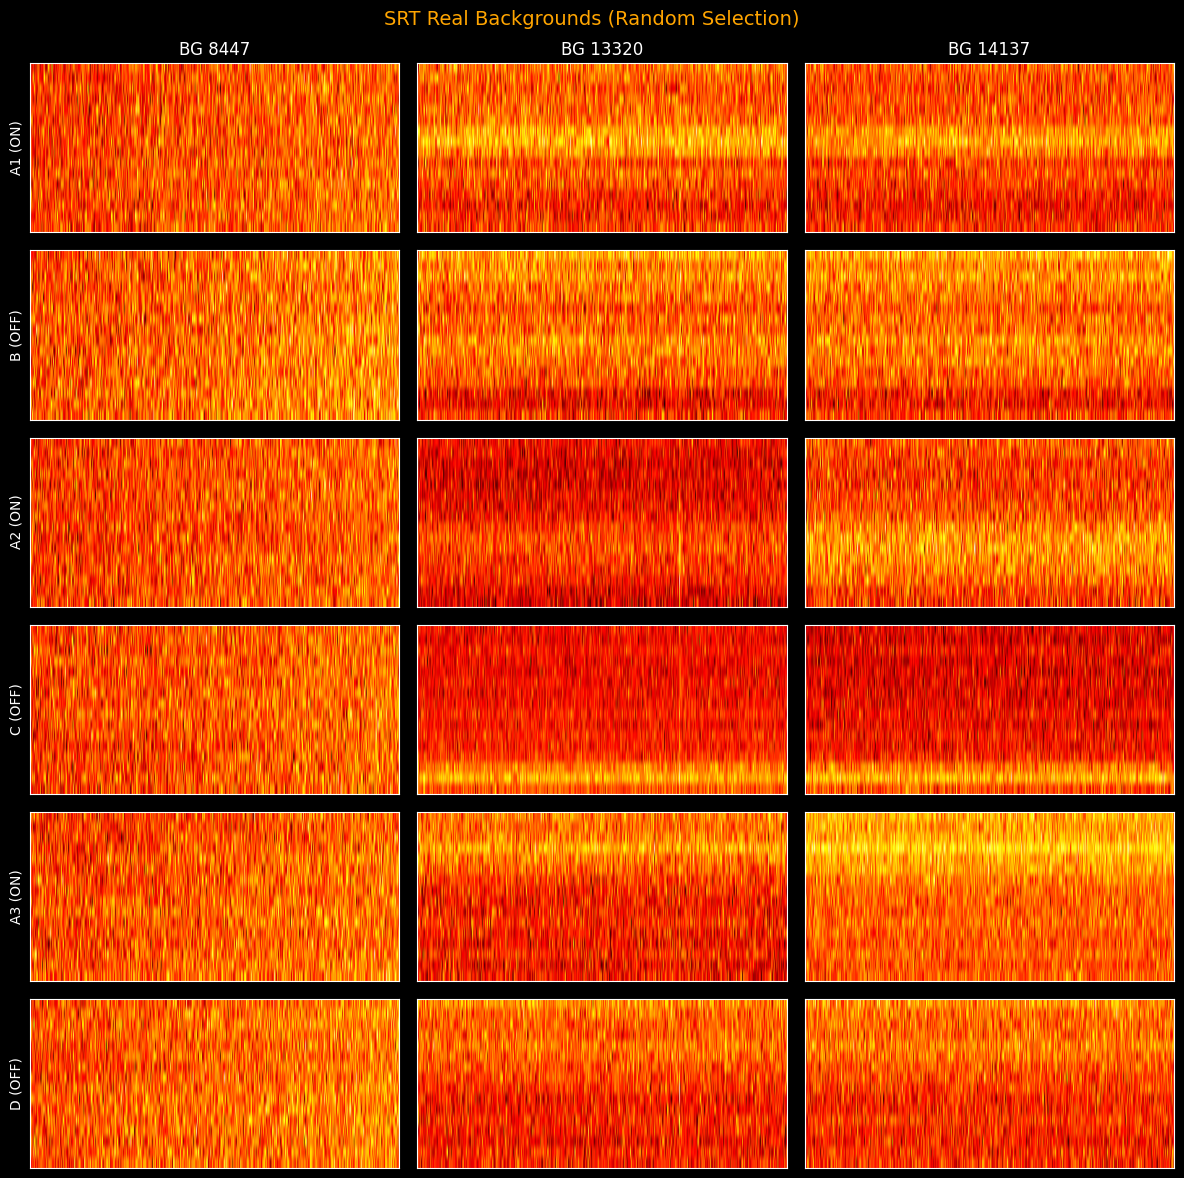

In [19]:
if plates is not None:
    n_samples = 3
    indices = np.random.choice(len(plates), n_samples, replace=False)
    labels = ['A1 (ON)', 'B (OFF)', 'A2 (ON)', 'C (OFF)', 'A3 (ON)', 'D (OFF)']

    fig, axes = plt.subplots(6, n_samples, figsize=(4*n_samples, 12))

    for col, idx in enumerate(indices):
        bg = plates[idx]
        for row in range(6):
            obs = bg[row].reshape(16, 512, 8).mean(axis=2)
            axes[row, col].imshow(normalize_log(obs), aspect='auto', cmap='hot', vmin=0, vmax=1)
            if col == 0:
                axes[row, col].set_ylabel(labels[row], fontsize=10)
            if row == 0:
                axes[row, col].set_title(f'BG {idx}', fontsize=12)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])

    plt.suptitle('SRT Real Backgrounds (Random Selection)', fontsize=14, color='orange')
    plt.tight_layout()
    plt.show()

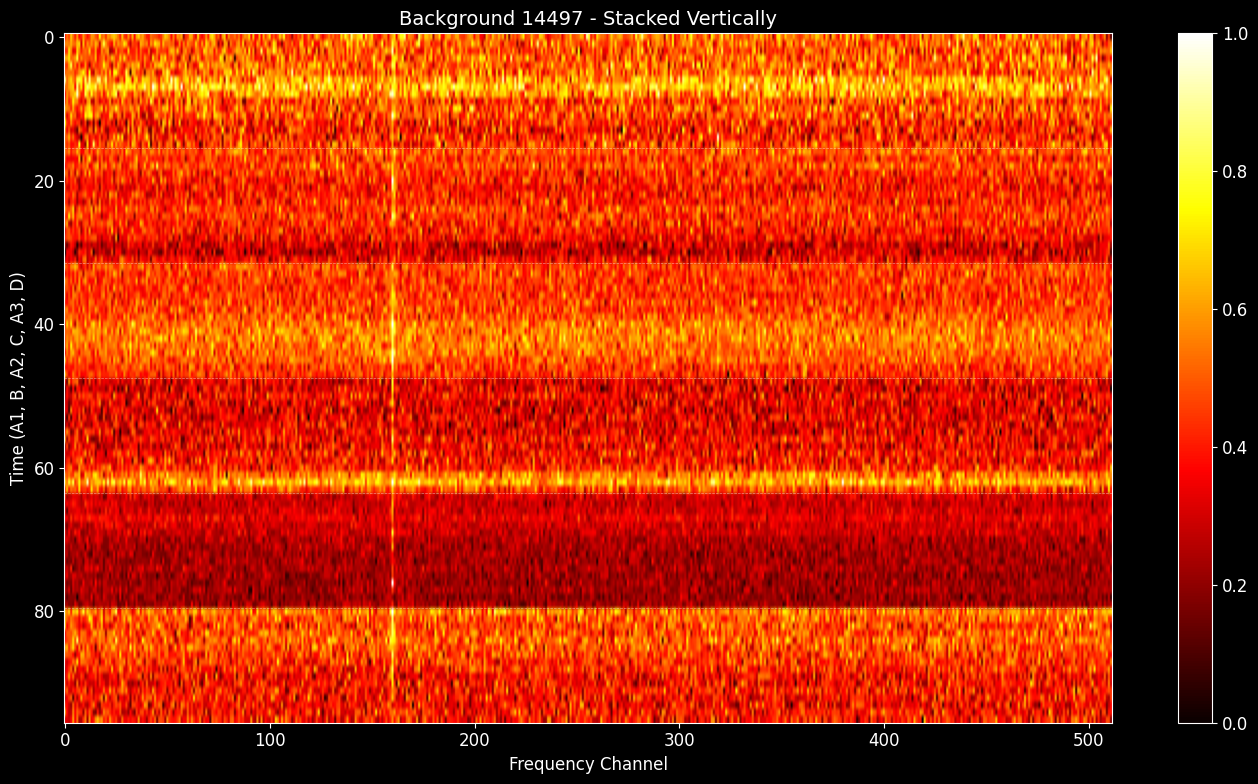

In [36]:
if plates is not None:
    idx = np.random.randint(len(plates))
    bg = plates[idx]

    stacked = np.vstack([normalize_log(bg[i].reshape(16, 512, 8).mean(axis=2)) for i in range(6)])

    fig, ax = plt.subplots(figsize=(14, 8))
    im = ax.imshow(stacked, aspect='auto', cmap='hot', vmin=stacked.min(), vmax=stacked.max())
    ax.set_title(f'Background {idx} - Stacked Vertically', fontsize=14)
    ax.set_xlabel('Frequency Channel')
    ax.set_ylabel('Time (A1, B, A2, C, A3, D)')

    for i in range(1, 6):
        ax.axhline(y=i*16-0.5, color='white', linewidth=0.5, linestyle='--', alpha=0.5)

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

## 3. Confronto: Sintetico vs Reale

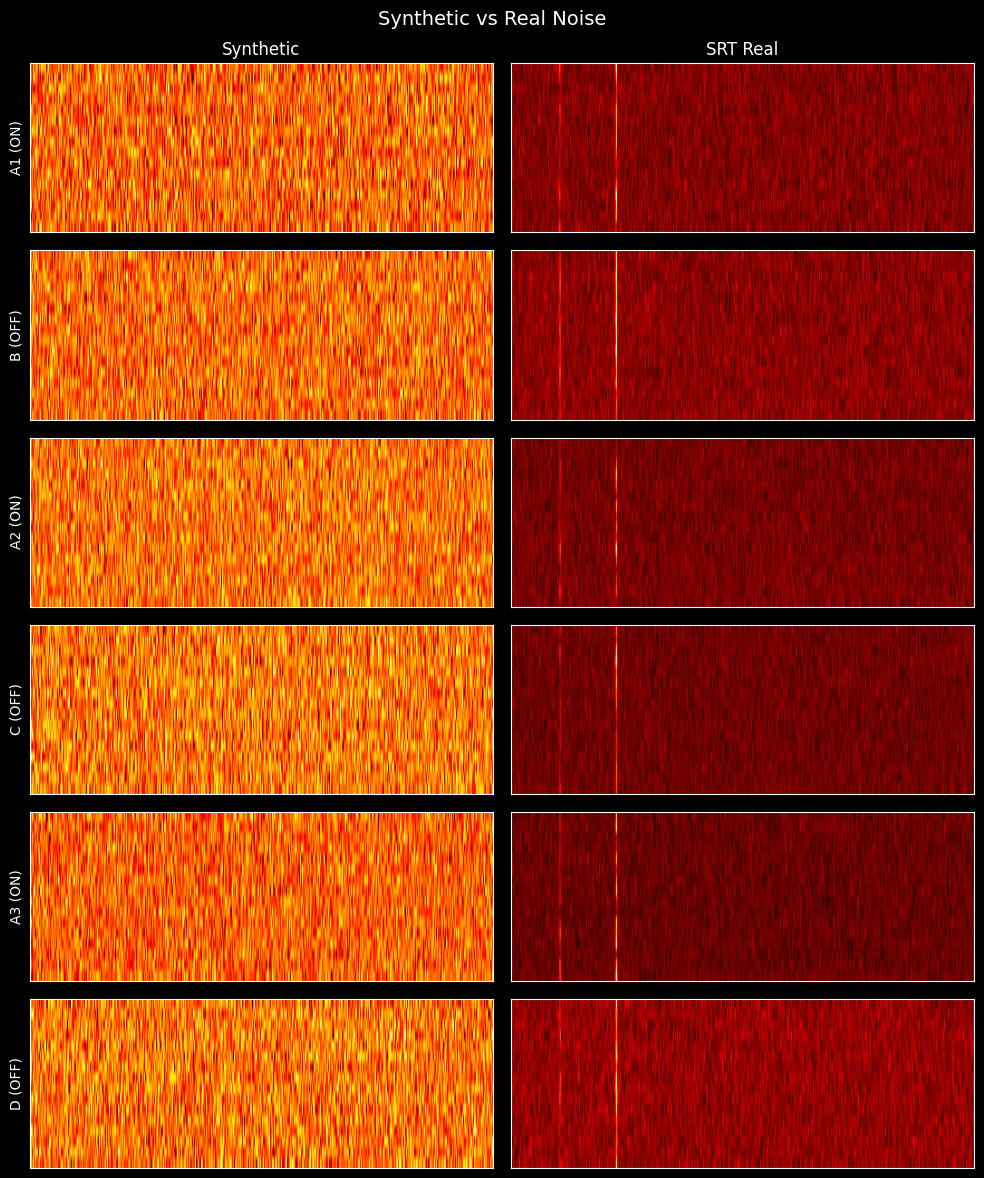

In [43]:
if plates is not None:
    labels = ['A1 (ON)', 'B (OFF)', 'A2 (ON)', 'C (OFF)', 'A3 (ON)', 'D (OFF)']
    fig, axes = plt.subplots(6, 2, figsize=(10, 12))

    # Synthetic (random seed = None)
    if CadenceGenerator is not None:
        synth_gen = CadenceGenerator(CadenceParams(fchans=512, tchans=16), seed=None)
        synth_bg = synth_gen._get_background()
        for row in range(6):
            axes[row, 0].imshow(normalize_log(synth_bg[row]), aspect='auto', cmap='hot', vmin=0, vmax=1)
            axes[row, 0].set_ylabel(labels[row], fontsize=10)
            axes[row, 0].set_xticks([])
            axes[row, 0].set_yticks([])
        axes[0, 0].set_title('Synthetic', fontsize=12)
    else:
        for row in range(6):
            axes[row, 0].text(0.5, 0.5, 'N/A', ha='center', va='center', transform=axes[row, 0].transAxes)
            axes[row, 0].set_ylabel(labels[row], fontsize=10)
        axes[0, 0].set_title('Synthetic (N/A)', fontsize=12)

    # Real (random)
    real_bg = plates[np.random.randint(len(plates))]
    for row in range(6):
        obs = real_bg[row].reshape(16, 512, 8).mean(axis=2)
        axes[row, 1].imshow(normalize_log(obs), aspect='auto', cmap='hot', vmin=0, vmax=1)
        axes[row, 1].set_xticks([])
        axes[row, 1].set_yticks([])
    axes[0, 1].set_title('SRT Real', fontsize=12)

    plt.suptitle('Synthetic vs Real Noise', fontsize=14)
    plt.tight_layout()
    plt.show()

## 4. TRUE vs FALSE con Background SRT

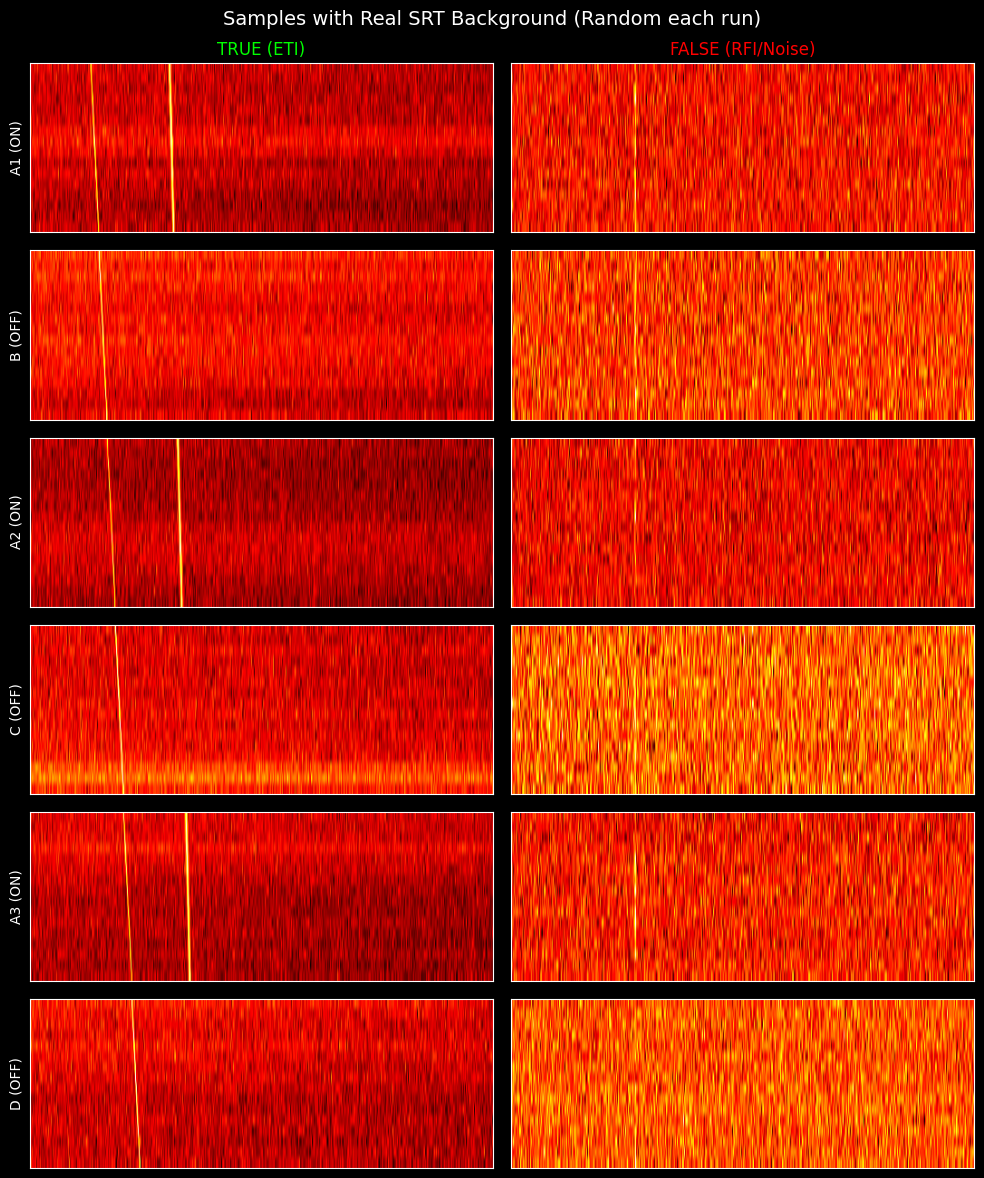

In [51]:
if plates is not None and CadenceGenerator is not None:
    # seed=None -> different results each run
    srt_gen = CadenceGenerator(
        CadenceParams(fchans=4096, tchans=16, snr_base=30, snr_range=20),
        plate=plates, seed=None
    )

    true_srt = srt_gen.create_true_sample_fast()
    false_srt = srt_gen.create_false_sample()

    labels = ['A1 (ON)', 'B (OFF)', 'A2 (ON)', 'C (OFF)', 'A3 (ON)', 'D (OFF)']
    fig, axes = plt.subplots(6, 2, figsize=(10, 12))

    for row in range(6):
        # TRUE
        obs = true_srt[row].reshape(16, 512, 8).mean(axis=2)
        axes[row, 0].imshow(normalize_log(obs), aspect='auto', cmap='hot', vmin=0, vmax=1)
        axes[row, 0].set_ylabel(labels[row], fontsize=10)
        axes[row, 0].set_xticks([])
        axes[row, 0].set_yticks([])

        # FALSE
        obs = false_srt[row].reshape(16, 512, 8).mean(axis=2)
        axes[row, 1].imshow(normalize_log(obs), aspect='auto', cmap='hot', vmin=0, vmax=1)
        axes[row, 1].set_xticks([])
        axes[row, 1].set_yticks([])

    axes[0, 0].set_title('TRUE (ETI)', fontsize=12, color='lime')
    axes[0, 1].set_title('FALSE (RFI/Noise)', fontsize=12, color='red')

    plt.suptitle('Samples with Real SRT Background (Random each run)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print('CadenceGenerator not available')

## 6. Statistiche Plate

Mean power: 1.66e+06
Std power:  3.34e+05
Min:        5.40e+05
Max:        2.29e+07


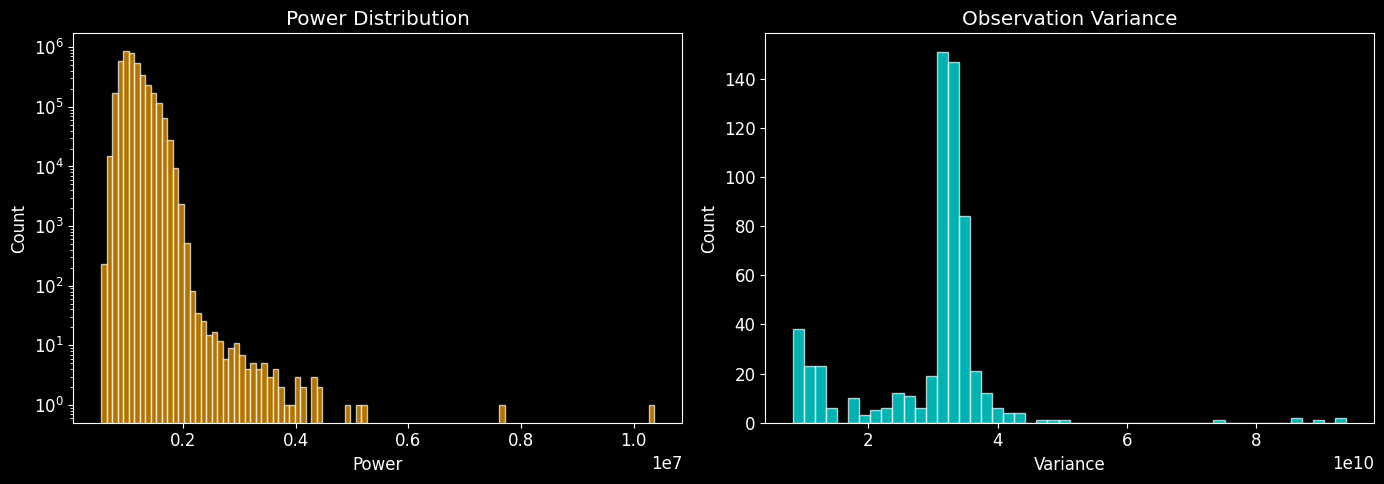

In [52]:
if plates is not None:
    sample = plates[:min(100, len(plates))]

    print(f'Mean power: {np.mean(sample):.2e}')
    print(f'Std power:  {np.std(sample):.2e}')
    print(f'Min:        {np.min(sample):.2e}')
    print(f'Max:        {np.max(sample):.2e}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(sample[:10].flatten(), bins=100, color='orange', alpha=0.7, edgecolor='white')
    axes[0].set_xlabel('Power')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Power Distribution')
    axes[0].set_yscale('log')

    var_per_obs = [np.var(obs) for bg in sample for obs in bg]
    axes[1].hist(var_per_obs, bins=50, color='cyan', alpha=0.7, edgecolor='white')
    axes[1].set_xlabel('Variance')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Observation Variance')

    plt.tight_layout()
    plt.show()